<a href="https://colab.research.google.com/github/darren-source/ICU-DIscharge/blob/main/Copy_of_Untitled96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Challenge: Monet-Style Image Generation with GANs

## Overview
In this project, I was tasked with developing a **Generative Adversarial Network (GAN)** capable of generating images in the style of Claude Monet, starting from photographs. The GAN will be structured into two main components:

- **Generator**: This neural network learns from actual Monet paintings to generate new images that mimic Monet's distinct style.
- **Discriminator**: This neural network evaluates the authenticity of each image by distinguishing between real Monet paintings and those created by the Generator.

The primary goal for the Generator is to "trick" the Discriminator into classifying a generated image as real. This adversarial training process is critical for producing more convincing Monet-style images as the project progresses.

## Dataset
The competition dataset is comprised of:
- **Real Monet Paintings**: These are used as a reference for the Generator to learn and capture the unique style of Monet.
- **Photographs**: These serve as the starting input for the Generator, which it will transform into Monet-style images.

Participants are encouraged to explore additional datasets for further experimentation and enhancement of their models.

## Model Requirements
The GAN must generate between 7,000 to 10,000 Monet-style images with the following specifications:
- **Format**: JPG
- **Resolution**: 256x256 pixels
- **Color Space**: RGB

## Output Specifications
The final output should be compiled into a single ZIP file named `images.zip`, containing all the generated images.

In [1]:
# Upload files to google Colab
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"darrencampbell","key":"502348006584c846a8f647ac1e8d4cda"}'}

In [2]:
# Create a directory to store the kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download data from the kaggle competition
!kaggle competitions download -c gan-getting-started

 97% 357M/367M [00:02<00:00, 141MB/s]
100% 367M/367M [00:02<00:00, 140MB/s]


In [4]:
# Unzip the downloaded data
!unzip -q gan-getting-started.zip

In [5]:
# List all files
!ls

gan-getting-started.zip  kaggle.json  monet_jpg  monet_tfrec  photo_jpg  photo_tfrec  sample_data


In [6]:
# Import libraries needed for data manipulation and graphics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Import tensor libraries for machine learning
import tensorflow as tf
from tensorflow import keras
# Import library for image manipulation
from PIL import Image
import os



# Exploratory Data Analysis (EDA)

## Overview

In this section of the project, I conducted an Exploratory Data Analysis (EDA) to understand the characteristics of the datasets and to prepare them for training in the CycleGAN model. The EDA involved inspecting and processing images, analyzing their color distributions, and setting up a pipeline for efficient model training.

## Visual Inspection

- **Comparison Objective**: The goal was to identify stylistic differences between Monet paintings and photographs.
- **Methodology**: We loaded 15 images of each type to allow direct visual comparisons.
  - **Monet Paintings**: Characterized by brushstroke textures and a more abstract representation of reality.
  - **Photographs**: Displayed sharper details and a more realistic portrayal.

## Color Distribution Analysis

- **Objective**: To compare how colors are utilized differently between Monet paintings and photographs.
- **Analysis**:
  - **Monet Paintings**: Tend to use a more concentrated color palette.
  - **Photographs**: Exhibit a more balanced distribution across red, green, and blue channels.
- **Tool Used**: Color histograms were utilized to visualize and compare the distribution of pixel values.

## Image Processing

- **Goal**: To prepare both datasets for the CycleGAN model.
- **Procedures**:
  - **Decoding**: Images were decoded into tensor format.
  - **Resizing**: Images resized to 256x256 pixels to ensure uniformity.
  - **Normalization**: Pixel values were normalized to a range of [-1, 1] to facilitate model training.

## Dataset Preparation

- **Objective**: To create TensorFlow datasets for both Monet paintings and photographs.
- **Benefits**: Ensures efficient data loading and batching during model training, crucial for handling large volumes of data.

## Conclusion

The EDA process provided valuable insights into the distinct characteristics of Monet paintings and photographs. This preliminary analysis was crucial for the subsequent model training phase, ensuring that the CycleGAN is trained on well-prepared datasets, leading to more effective learning and generation of Monet-style images.

In [8]:
# Display a list of images in a grid
def display_images(images, title=None, cols=5, rows=3, figsize=(15, 10)):
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    axs = axs.flatten()
    for img, ax in zip(images, axs):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout(pad=0.1)
    if title:
        plt.suptitle(title, fontsize=20)
    plt.show()

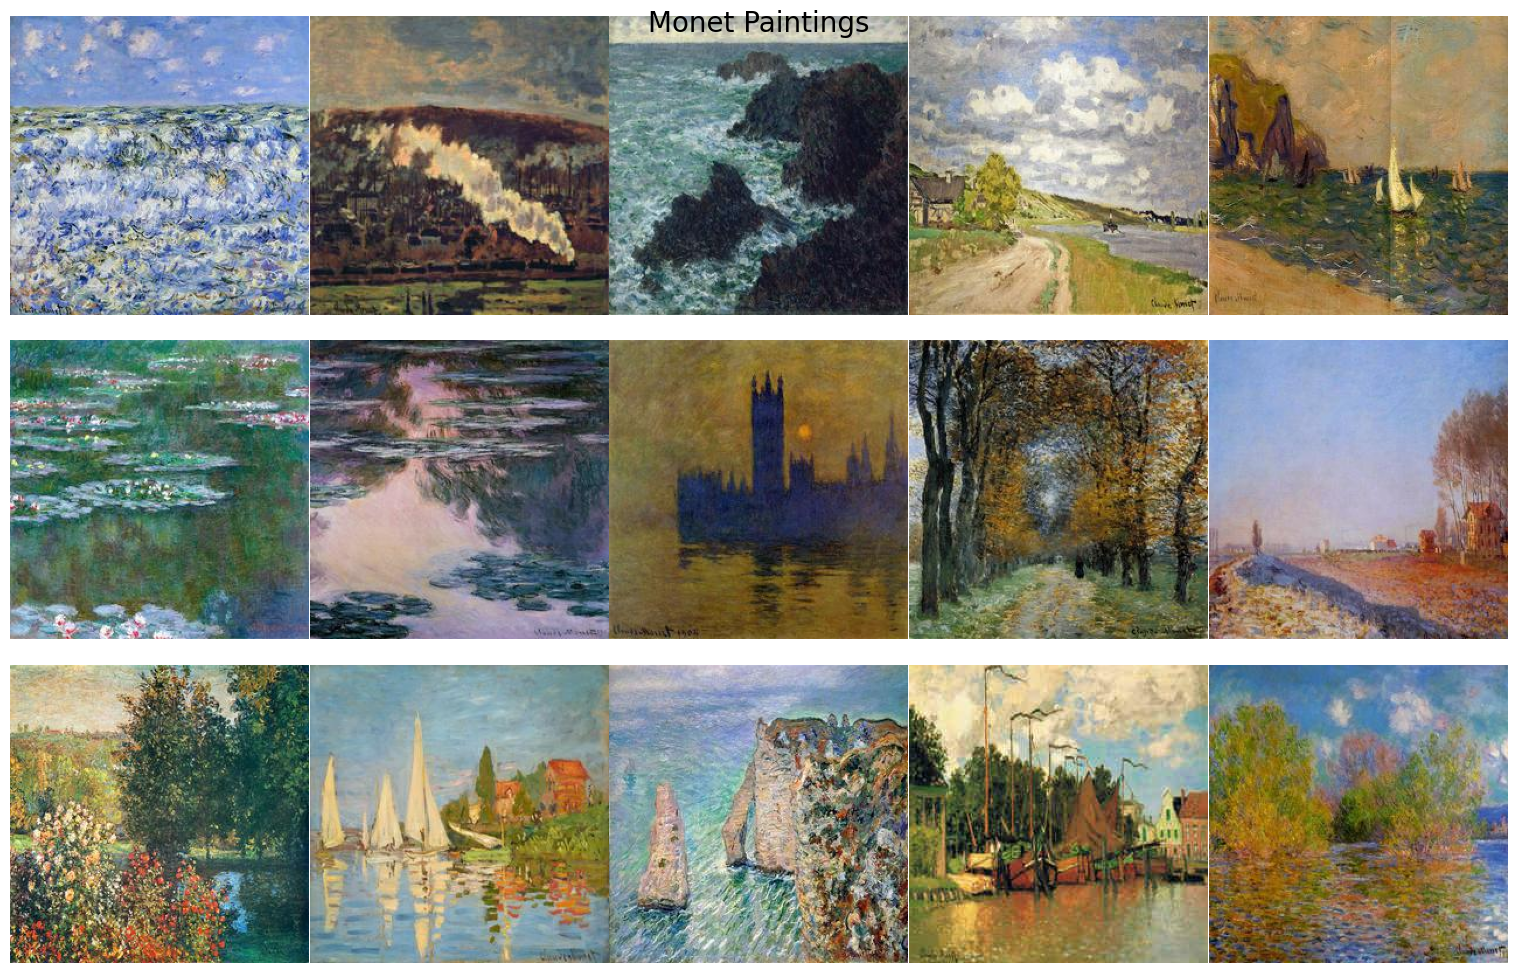

In [9]:
monet_dir = 'monet_jpg'
monet_images = [Image.open(os.path.join(monet_dir, file)) for file in os.listdir(monet_dir)[:15]]
display_images(monet_images, title='Monet Paintings')

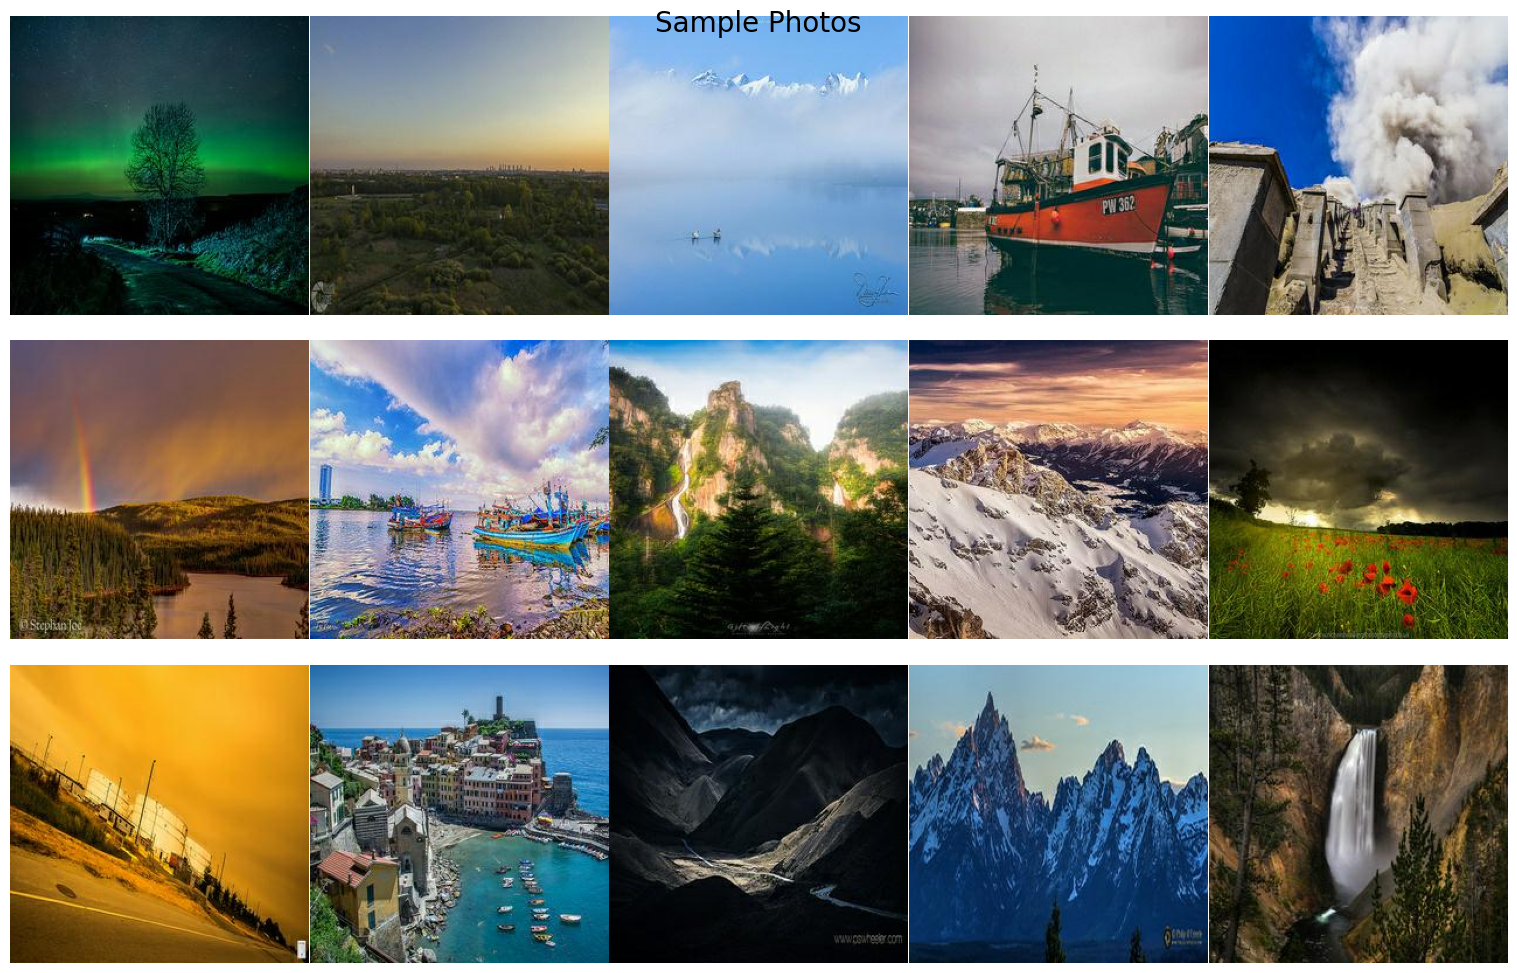

In [10]:
photo_dir = 'photo_jpg'
photo_images = [Image.open(os.path.join(photo_dir, file)) for file in os.listdir(photo_dir)[:15]]
display_images(photo_images, title='Sample Photos')


Monet Image


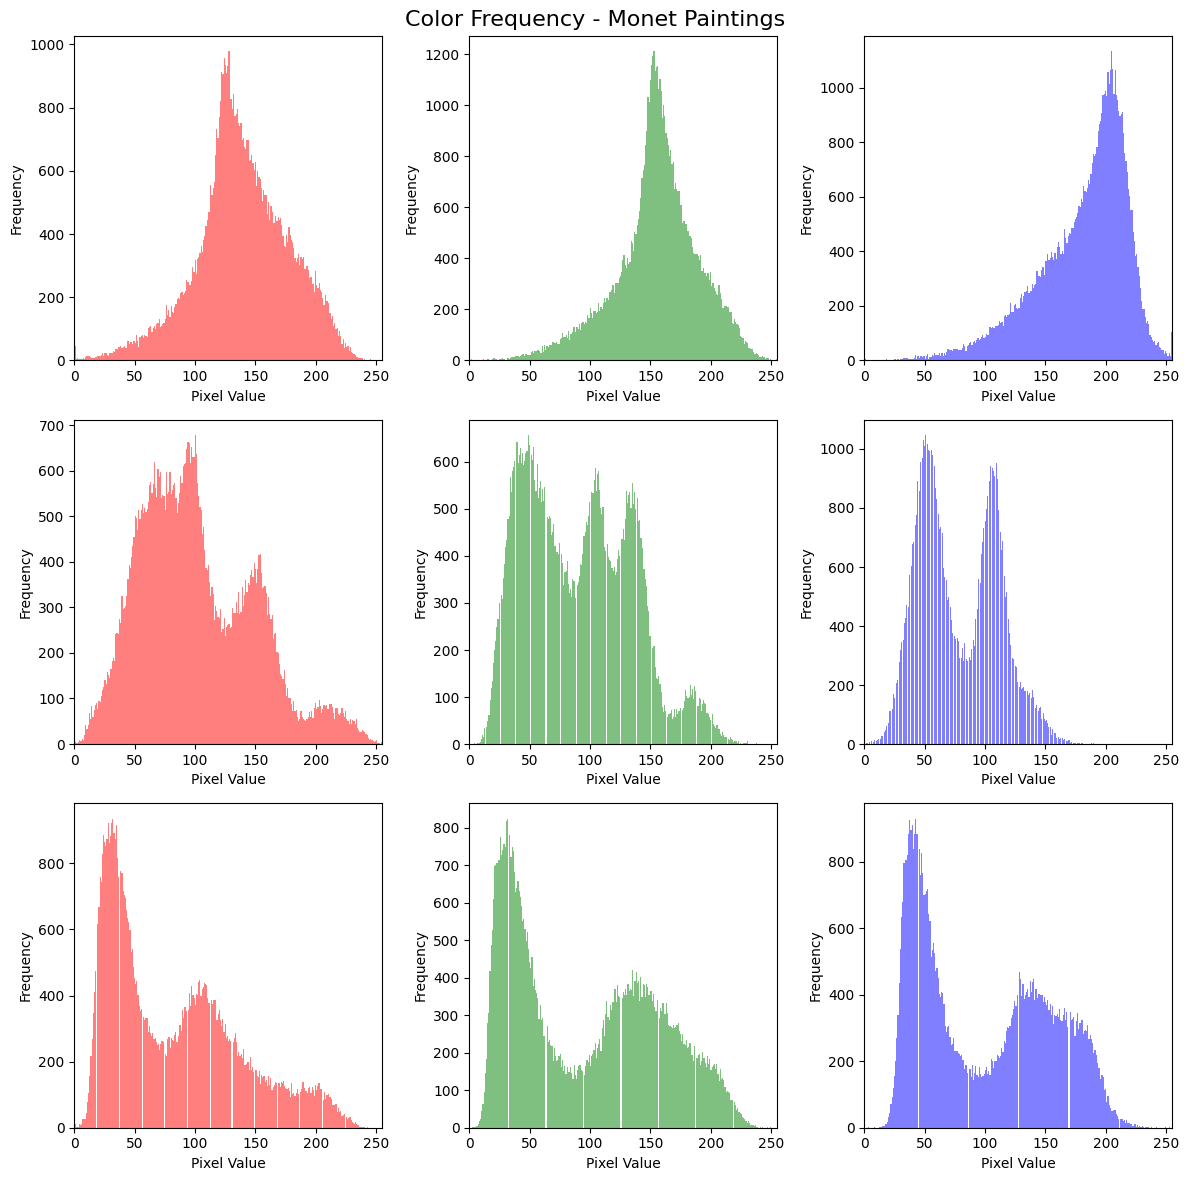

--------------------------
Photograph


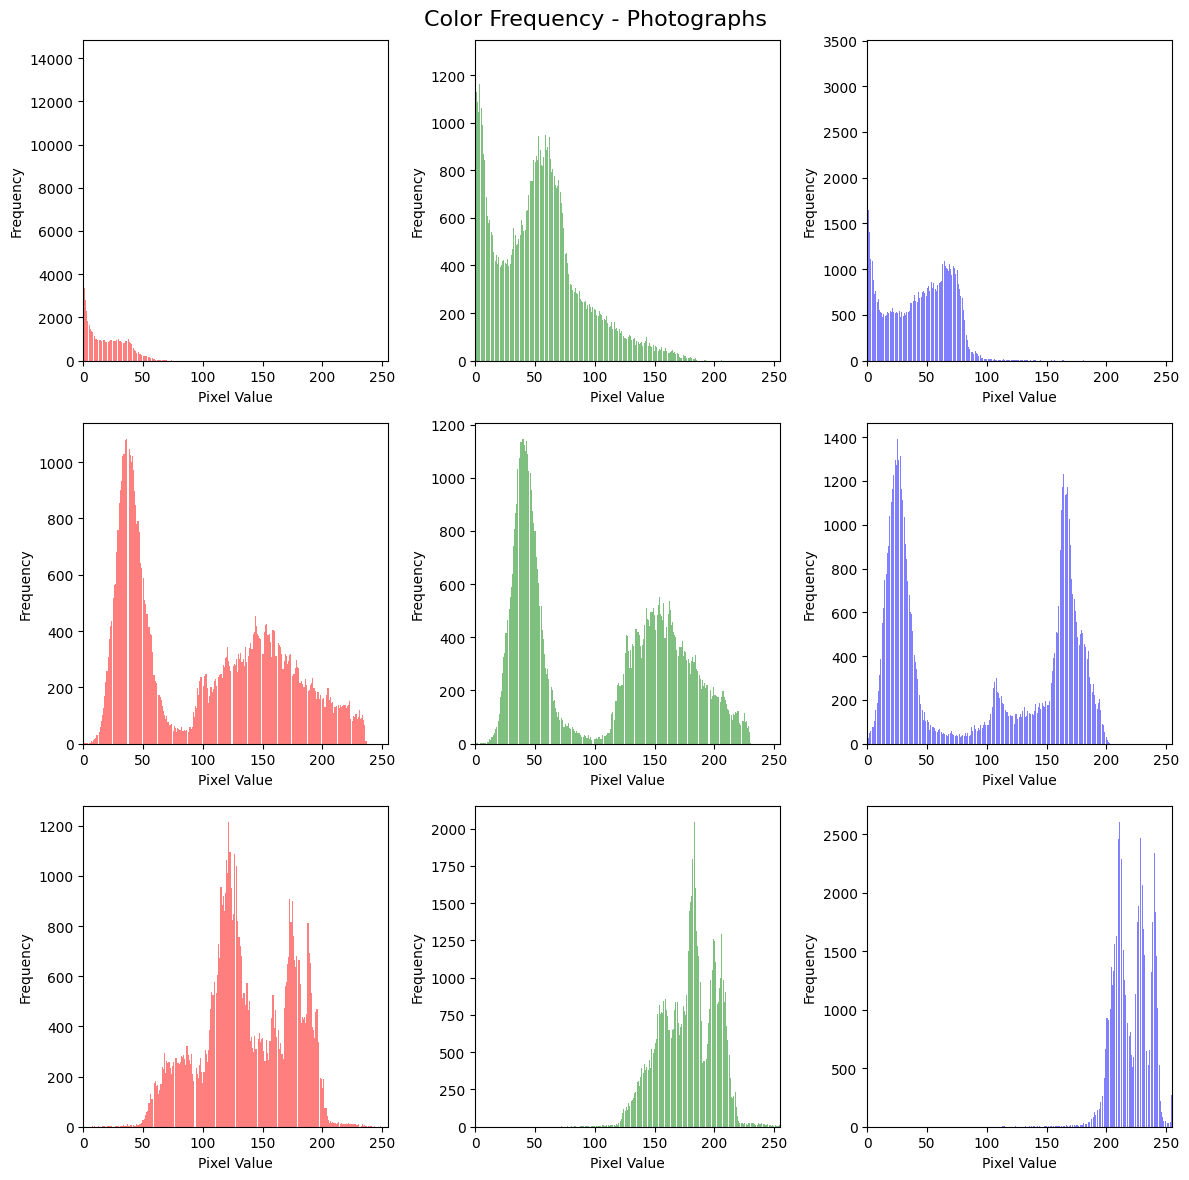

In [11]:
# Function that generates histograms to analyze the distribution of pixel value
def plot_color_histograms(image_paths, title):
    fig, axes = plt.subplots(len(image_paths), 3, figsize=(12, 4*len(image_paths)))
# Create a grid of subplots
    for idx, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        image = image.resize((256, 256))
# Convert image to numpy
        image_array = np.array(image)

        colors = ('red', 'green', 'blue')
        for i , color in enumerate(colors):
            ax = axes[idx, i] if len(image_path) > 1 else axes[i]
            ax.hist(image_array[..., i].ravel(), bins=256, color=color, alpha=0.5)
            ax.set_xlim([0, 255])
            ax.set_xlabel('Pixel Value')
            ax.set_ylabel('Frequency')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

monet_dir = 'monet_jpg'
photo_dir = 'photo_jpg'

monet_jpg = [os.path.join(monet_dir, file) for file in os.listdir(monet_dir)[:3]]
photo_jpg = [os.path.join(photo_dir, file) for file in os.listdir(photo_dir)[:3]]

print('Monet Image')
plot_color_histograms(monet_jpg[:3], title='Color Frequency - Monet Paintings')
print('--------------------------')
print('Photograph')
plot_color_histograms(photo_jpg[:3], title='Color Frequency - Photographs')

In [12]:
# Import layers module
from tensorflow.keras import layers


In [13]:
img_height = 256
img_width = 256
buffer = 1000
batch = 1
# Function that takes an image file path as input, reads and processes the file to be used in deep learning
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3) # File decoded to tensor format
    image = tf.image.resize(image, [img_height, img_width]) # resize image
    image = (image - 127.5) / 127.5 # normalize pictures
    return image
# Creates a list containing the full paths of all files in the monet_dir
monet_image_paths = [os.path.join(monet_dir, file) for file in os.listdir(monet_dir)]
# Creates a list containing the full paths of all files in the photo_image_dir
photo_image_paths = [os.path.join(photo_dir, file) for file in os.listdir(photo_dir)]
# Create a tensorflow dataset
monet_ds = tf.data.Dataset.from_tensor_slices(monet_image_paths).map(preprocess_image).shuffle(buffer).batch(batch)
photo_ds = tf.data.Dataset.from_tensor_slices(photo_image_paths).map(preprocess_image).shuffle(buffer).batch(batch)

# Model Building and Training: CycleGAN

## Overview

The CycleGAN model is designed to learn bidirectional transformations between two different image domains. It utilizes two generators and two discriminators, each serving specific roles within the adversarial training framework.

## Model Architecture

- **Generators**:
  - **Generator G**: Transforms images from the Photograph domain to the Monet paintings domain.
  - **Generator F**: Transforms images from the Monet paintings domain to the Photograph domain.

- **Discriminators**:
  - **Discriminator X**: Distinguishes between real and fake photographs.
  - **Discriminator Y**: Distinguishes between real and fake Monet paintings.

## Loss Functions

The CycleGAN model uses multiple loss functions to guide the training process:

- **Adversarial Loss**: Encourages each generator to produce images that the respective discriminator cannot distinguish from real images in the target domain.
- **Cycle Consistency Loss**: Ensures that an image can be transformed from one domain to another and back again, maintaining key features of the original image.
- **Identity Loss**: Promotes the preservation of characteristics in images that are already in the target domain, when processed by the generators.

## Optimization Strategy

- **Optimizer**: Adam optimizer is employed for both generators and discriminators. It is favored in GANs due to its adaptive learning rate capabilities and momentum-based updates, which contribute to stabilizing the training process.
- **Weight Updates**: Gradients are calculated and applied to update the model weights during each training iteration, facilitating the learning process.

## Model Evaluation

- **Monitoring**: The losses for both generators and discriminators are tracked throughout training to gauge improvement and ensure that the model is learning effectively.


In [14]:
# Creates a Generator function that creates a generator model
# Generator's role is to input images and transform it into an output image
def build_generator():
    inputs = layers.Input(shape=[img_height, img_width, 3])
# reduces dimensions
    down_stack = [
        layers.Conv2D(64, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(128, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(256, 4, strides=2, padding='same', activation='relu'),
    ]
# creates a list of layers that return the image to the original size
    up_stack = [
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh'),
    ]
# Building the model with downsampling and upsampling
    x = inputs
    for down in down_stack:
        x = down(x)
    for up in up_stack:
        x = up(x)
# Return the Generated Model
    return keras.Model(inputs=inputs, outputs=x)

In [15]:
# Creates a Discriminator model to distinguish real images from fake images
def build_discriminator():
    inputs = layers.Input(shape=[img_height, img_width, 3])

    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(1, 4, padding='same')(x)
# Return the Discriminator Model
    return keras.Model(inputs=inputs, outputs=x)

In [16]:
# two generators create images that attempt to fool the discriminator into thinking the images are real
generator_g = build_generator()
generator_f = build_generator()
# the two discriminators try to distinguish between real images  from each domain
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

In [17]:
# Setting up lose functions for adversarial training
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Function defines how the discriminator in a GAN evaluates performance when distinguishing between real
# and fake images
def discriminator_loss(real, generated):
    real_loss = loss_object(tf.ones_like(real), real)
    generated_loss = loss_object(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5
# Function measures has well the generator is doing at fooling the discriminator into believing the
# images are real
def generator_loss(generated):
    return loss_object(tf.ones_like(generated), generated)
# Function ensures that when an image is transfered from one domain to another, the result is as close as
# possible to the original image
def cycle_consistency_loss(real_image, cycled_image, LAMBDA=10):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss
# Function encourages the generator to preserve certain aspects of the image when it is not
# supposed to change styles
def identity_loss(real_image, same_image, LAMBDA=10):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [18]:
# Setting up the optimizers for the generator and discriminator
# Uses Adam optimizer
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# Decorator tells Tensor Flow to compile the train_step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
# Generates fake images and cycles them back to the original domain
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
# Discriminators' outputs for real or fake images, classifies whether images are
# real or fake
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
# Calculate the generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
# Calculate total loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
# Compute the gradients for each model and adjust each parameter
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))
# Return the loss values for tracking and monitoring during training
    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss,
    }

In [19]:
# Define the number of Epochs
epochs = 10
# Training Loop runs for a specific number of epochs
for epoch in range(epochs):

    for real_x, real_y in tf.data.Dataset.zip((photo_ds, monet_ds)):
        losses = train_step(real_x, real_y)
# Print the current epoch number and keep track of progress
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Generator G loss: {losses['gen_g_loss']}, Generator F loss: {losses['gen_f_loss']}")
    print(f"Discriminator X loss: {losses['disc_x_loss']}, Discriminator Y loss: {losses['disc_y_loss']}")

Epoch 1/10
Generator G loss: 3.895636558532715, Generator F loss: 3.8356847763061523
Discriminator X loss: 0.8573889136314392, Discriminator Y loss: 0.6215367317199707
Epoch 2/10
Generator G loss: 4.254676818847656, Generator F loss: 4.294990539550781
Discriminator X loss: 0.6069331765174866, Discriminator Y loss: 0.5678220391273499
Epoch 3/10
Generator G loss: 4.055752754211426, Generator F loss: 3.9521102905273438
Discriminator X loss: 1.0159549713134766, Discriminator Y loss: 0.5604991912841797
Epoch 4/10
Generator G loss: 4.4046549797058105, Generator F loss: 4.134084701538086
Discriminator X loss: 0.6309669017791748, Discriminator Y loss: 0.6742395758628845
Epoch 5/10
Generator G loss: 3.3509321212768555, Generator F loss: 3.572399139404297
Discriminator X loss: 0.4481247067451477, Discriminator Y loss: 0.6756545901298523
Epoch 6/10
Generator G loss: 4.295583724975586, Generator F loss: 4.389881134033203
Discriminator X loss: 0.45451483130455017, Discriminator Y loss: 0.5154713392

# Results and Conclusion

## Training Overview

The CycleGAN model underwent training over **10 epochs**. Here's a summary of the performance dynamics observed during the training period:

- **Generator Loss**: Throughout the 10 epochs, the losses for both generators remained high but showed signs of stabilization. A decreasing generator loss indicates that the generators are progressively becoming better at deceiving the discriminators.
- **Discriminator Loss**: The discriminator losses exhibited fluctuations across the epochs. A lower discriminator loss suggests improvements in the discriminators' ability to distinguish between real and fake images.

## Conclusion

The CycleGAN model demonstrated steady learning progress across the 10 epochs. Although it did not fully converge within this period, both the generator and discriminator showed enhanced performance, suggesting that extending the number of epochs could lead to further improvements.

## Recommendations for Improvement

- **Early Stopping**: Implement an early stopping mechanism to monitor loss values closely. This approach helps prevent overfitting by halting training when the model's performance on the validation set ceases to improve.

By continuing to refine these aspects, the CycleGAN model can achieve higher accuracy and efficiency in transforming images between the domains of photographs and Monet-style paintings.

In [20]:
# Libraries needed to generate and save images produced by a trained CycleGAN model
import io
import os
import zipfile
from PIL import Image
import tensorflow as tf
# Setting up location where created images will be saved and number of images produced
output_zip = "/kaggle/working/images.zip"
num_images = 7000

os.makedirs(os.path.dirname(output_zip), exist_ok=True)

# Open a zip file to store images
with zipfile.ZipFile(output_zip, 'w') as zipf:
    for i, photo in enumerate(photo_ds.take(num_images)):
        # Generate image using the generator
        generated_image = generator_g(photo, training=False)[0]  # Assuming the generator returns a batch
        # Normalize the image to 0-255 and convert to uint8
        generated_image = ((generated_image * 0.5 + 0.5) * 255).numpy().astype('uint8')
        # Convert the numpy array to an image
        img = Image.fromarray(generated_image)

        # Define the filename for each generated image
        image_filename = f"image_{i+1}.jpg"
        # Save each image to the zip file
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='JPEG')
        img_byte_arr = img_byte_arr.getvalue()
        zipf.writestr(image_filename, img_byte_arr)

        # Print progress every 500 images
        if (i + 1) % 500 == 0:
            print(f"{i+1}/{num_images} images written to zip.")

print("All images have been written to images.zip.")

500/7000 images written to zip.
1000/7000 images written to zip.
1500/7000 images written to zip.
2000/7000 images written to zip.
2500/7000 images written to zip.
3000/7000 images written to zip.
3500/7000 images written to zip.
4000/7000 images written to zip.
4500/7000 images written to zip.
5000/7000 images written to zip.
5500/7000 images written to zip.
6000/7000 images written to zip.
6500/7000 images written to zip.
7000/7000 images written to zip.
All images have been written to images.zip.
